# T025 · Kinase similarity: Kinase pocket (KiSSim fingerprint)

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will assess the similarity between a set of kinases from a structural point of view using the [KiSSim](https://kissim.readthedocs.io/en/latest/) fingerprint. This fingerprint describes the physicochemical and spatial properties in structurally resolved kinases.

_Note_: We focus on similarities between orthosteric kinase binding sites; similarities to allosteric binding sites are not covered.

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor: Kinase pockets (KiSSim fingerprint)
* Fetching KLIFS data with `opencadd.databases.klifs`

### Contents in *Practical*

* Define the kinases of interest
* Retrieve and preprocess data
    * Set up a remote KLIFS session
    * Fetch all structures describing these kinases
    * Filter structures
* Show kinase coverage
* Calculate KiSSim fingerprints
* Compare structures
* Map structure to kinase distance matrix
* Save kinase distance matrix

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* Protein Data Bank
  * PDB URL: http://www.rcsb.org/
  * PDB database: [<i>Acta Cryst.</i> (2002), <b>D58</b>, 899-907](https://doi.org/10.1107/S0907444902003451) and [<i>Structure</i> (2012), <b>20(3)</b>, 391-396](https://doi.org/10.1016/j.str.2012.01.010)
* KLIFS
  * KLIFS URL: https://klifs.net/
  * KLIFS database: [<i>Nucleic Acid Res.</i> (2020), <b>49(D1)</b>, D562-D569](https://doi.org/10.1093/nar/gkaa895)
  * KLIFS binding site definition: [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w)
 * Binding site comparison reviews: 
   * [<i>Curr. Comput. Aided Drug Des. </i> (2008), <b>4</b>, 209-20](https://www.eurekaselect.com/67606/article/how-measure-similarity-between-protein-ligand-binding-sites)
    * [<i>J. Med. Chem. </i> (2016), <b>9</b>, 4121-51](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b00078)
* KiSSim: Kinase Structural Similarity
  * GitHub repository: https://github.com/volkamerlab/kissim
  * Documentation: https://kissim.readthedocs.io
* `opencadd`, a Python library for structural cheminformatics
  * GitHub repository: https://github.com/volkamerlab/opencadd
  * Documentation: https://opencadd.readthedocs.io

## Theory

### Kinase dataset

We use the kinase selection as defined in __Talktorial T023__.

### Kinase similarity descriptor: Kinase pockets (KiSSim fingerprint)

Side effects often occur when a drug binds not only to its designated target (on-target) but also to other targets (off-targets) that share similar binding sites to form similar protein-ligand interaction patterns. Many binding site comparison tools have been proposed to predict similarities and potential off-targets (see [<i>Curr. Comput. Aided Drug Des. </i> (2008), <b>4</b>, 209-20](https://www.eurekaselect.com/67606/article/how-measure-similarity-between-protein-ligand-binding-sites) and [<i>J. Med. Chem. </i> (2016), <b>9</b>, 4121-51](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b00078)). 

Here we use the novel [KiSSim](https://kissim.readthedocs.io/en/latest/) (*Ki*nase *S*tructure *Sim*ilarity) fingerprint, which is based on the KLIFS pocket definition and alignment of $85$ pocket residues (see more details in __Talktorial T023__).

The KiSSim fingerprint encodes each of the $85$ residues in the KLIFS binding site with respect to physicochemical and spatial properties (Figure 1). Since all KLIFS pockets are aligned across the structurally covered kinome, we can compare the KiSSim fingerprints bit by bit. Physicochemical properties of each residue include pharmacophoric features, size, side chain orientation, and solvent exposure. Spatial properties describe the distance of each residue to defined important regions in the kinase pocket, for example the hinge region, which forms crucial hydrogen bonds to ligands, or the DFG region, whose conformation determines the activity state of the kinase. See more details on structural motifs in kinases in __Talktorial T023__.

![KiSSim fingerprint](https://raw.githubusercontent.com/volkamerlab/kissim/main/docs/_static/kissim_toc.png)

*Figure 1:* 
The KiSSim fingerprint encodes physicochemical and spatial properties of a kinase binding site.
Figure taken from: https://github.com/volkamerlab/kissim

### Fetching KLIFS data with `opencadd.databases.klifs`

`opencadd` is a Python library for structural cheminformatics developed by the [Volkamer lab](https://volkamerlab.org/) at the Charité in Berlin. 
This library is a growing collection of modules that help facilitate and standardize common tasks in structural bioinformatics and cheminformatics. Today, we will use the module `opencadd.databases.klifs`, which allows us to fetch the KLIFS structures as a `pandas` DataFrame.

- GitHub repository: https://github.com/volkamerlab/opencadd
- Documentation: https://opencadd.readthedocs.io

For more information about this library and the KLIFS OpenAPI, please refer to __Talktorial T012__.

## Practical

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_remote
import kissim

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
configs = pd.read_csv(HERE / "../T023_what_is_a_kinase/data/pipeline_configs.csv")
configs = configs.set_index("variable")["default_value"]

DEMO = bool(int(configs["DEMO"]))
N_STRUCTURES_PER_KINASE = int(configs["N_STRUCTURES_PER_KINASE"])
N_CORES = int(configs["N_CORES"])

print(f"Run in demo mode: {DEMO}")
if not DEMO:
    if N_STRUCTURES_PER_KINASE > 0:
        print(f"Number of structures per kinase: {N_STRUCTURES_PER_KINASE}")
    else:
        print(f"Number of structures per kinase: all available structures")
    print(f"Number of cores used: {N_CORES}")

# NBVAL_CHECK_OUTPUT

Run in demo mode: True


### Define the kinases of interest

Let's load the kinase selection as defined in __Talktorial T023__.

In [4]:
kinase_selection_df = pd.read_csv(HERE / "../T023_what_is_a_kinase/data/kinase_selection.csv")
kinase_selection_df
# NBVAL_CHECK_OUTPUT

,kinase,kinase_klifs,uniprot_id,group,full_kinase_name
0,EGFR,EGFR,P00533,TK,Epidermal growth factor receptor
1,ErbB2,ErbB2,P04626,TK,Erythroblastic leukemia viral oncogene homolog 2
2,PI3K,p110a,P42336,Atypical,Phosphatidylinositol-3-kinase
3,VEGFR2,KDR,P35968,TK,Vascular endothelial growth factor receptor 2
4,BRAF,BRAF,P15056,TKL,Rapidly accelerated fibrosarcoma isoform B
5,CDK2,CDK2,P24941,CMGC,Cyclic-dependent kinase 2
6,LCK,LCK,P06239,TK,Lymphocyte-specific protein tyrosine kinase
7,MET,MET,P08581,TK,Mesenchymal-epithelial transition factor
8,p38a,p38a,Q16539,CMGC,p38 mitogen activated protein kinase alpha


### Retrieve and preprocess data

Now, we query the KLIFS database using the `opencadd.databases.klifs` module to fetch available structures in KLIFS.

#### Set up a remote KLIFS session

In [5]:
from opencadd.databases.klifs import setup_remote

In [6]:
klifs_session = setup_remote()

#### Fetch all structures describing these kinases

In [7]:
# Get list of kinase names
kinase_names = kinase_selection_df["kinase_klifs"].to_list()

# Get all available structures for these kinases
structures_df = klifs_session.structures.by_kinase_name(kinase_names=kinase_names)
print(f"Number of structures: {len(structures_df)}")
print("Kinases:", *structures_df["kinase.klifs_name"].unique())

Number of structures: 2626
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


Let's have a look at what is stored in the structures' DataFrame:

In [8]:
structures_df.columns

Index(['structure.klifs_id', 'structure.pdb_id', 'structure.alternate_model',
       'structure.chain', 'species.klifs', 'kinase.klifs_id',
       'kinase.klifs_name', 'kinase.names', 'kinase.family', 'kinase.group',
       'structure.pocket', 'ligand.expo_id', 'ligand_allosteric.expo_id',
       'ligand.klifs_id', 'ligand_allosteric.klifs_id', 'ligand.name',
       'ligand_allosteric.name', 'structure.dfg', 'structure.ac_helix',
       'structure.resolution', 'structure.qualityscore',
       'structure.missing_residues', 'structure.missing_atoms',
       'structure.rmsd1', 'structure.rmsd2', 'interaction.fingerprint',
       'structure.front', 'structure.gate', 'structure.back', 'structure.fp_i',
       'structure.fp_ii', 'structure.bp_i_a', 'structure.bp_i_b',
       'structure.bp_ii_in', 'structure.bp_ii_a_in', 'structure.bp_ii_b_in',
       'structure.bp_ii_out', 'structure.bp_ii_b', 'structure.bp_iii',
       'structure.bp_iv', 'structure.bp_v', 'structure.grich_distance',
       

In [9]:
structures_df.head()

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,...,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,4293,3r28,B,A,Human,198,CDK2,<NA>,<NA>,<NA>,...,False,False,False,False,False,14.4586,50.037800,60.865299,<NA>,False
1,4448,1gii,-,A,Human,198,CDK2,<NA>,<NA>,<NA>,...,False,False,False,False,False,13.6741,46.511398,67.373398,<NA>,False
2,4447,3r7e,B,A,Human,198,CDK2,<NA>,<NA>,<NA>,...,False,False,False,False,False,14.4999,50.676300,63.416901,<NA>,False
3,4446,3bhu,B,A,Human,198,CDK2,<NA>,<NA>,<NA>,...,False,False,False,False,False,15.9950,53.229599,54.202202,<NA>,False
4,4251,3pxz,-,A,Human,198,CDK2,<NA>,<NA>,<NA>,...,False,False,False,False,False,13.8432,44.751900,93.933197,<NA>,False


#### Filter structures

We filter the structures by different criteria:

- Species: human
- Conformation: DFG-in (the active kinase conformation)
- Resolution: $\le 3$ Angström
- Quality score*: $\ge 6$

\* The KLIFS quality score takes into account the quality of the alignment, as well as the number of missing residues and atoms. A higher score indicates a better structure quality.

In [10]:
structures_df = structures_df[
    (structures_df["species.klifs"] == "Human")
    & (structures_df["structure.dfg"] == "in")
    & (structures_df["structure.resolution"] <= 3)
    & (structures_df["structure.qualityscore"] >= 6)
]
print(f"Number of structures: {len(structures_df)}")
print("Kinases:", *structures_df["kinase.klifs_name"].unique())

Number of structures: 1736
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


Save the structure KLIFS IDs for the next step.

In [11]:
structure_klifs_ids = structures_df["structure.klifs_id"].to_list()
print(f"Number of structures: {len(structure_klifs_ids)}")

Number of structures: 1736


_Note for demo mode_: To make it easier for us to maintain the talktorials, we will now load a set of frozen structure KLIFS IDs (2021-08-23) and continue to work with those.

_Note for non-demo mode_: Did you specify `N_STRUCTURES_PER_KINASE` in the configuration file? If you e.g. set a value of 3, we will select in the following the top 3 structures per kinase in terms of resolution and KLIFS quality score.

In [12]:
if DEMO:
    # Load frozen dataset
    print("Notebook is run in demo mode - load frozen structure set.")
    structure_klifs_ids = pd.read_csv(DATA / "frozen_structure_klifs_ids.csv")[
        "structure.klifs_id"
    ].to_list()
    structures_df = structures_df[
        structures_df["structure.klifs_id"].isin(structure_klifs_ids)
    ].copy()
else:
    if N_STRUCTURES_PER_KINASE > 0:
        print(f"Select {N_STRUCTURES_PER_KINASE} structures per kinase for downstream analysis.")
        # Sort structures by kinase and quality
        structures_df = structures_df.sort_values(
            by=["kinase.klifs_name", "structure.resolution", "structure.qualityscore"],
            ascending=[True, True, False],
        )
        # Reduce number of structures per kinase
        structures_df = structures_df.groupby("kinase.klifs_name").head(N_STRUCTURES_PER_KINASE)
        structure_klifs_ids = structures_df["structure.klifs_id"].to_list()
    else:
        print(f"Use all available structures per kinase for downstream analysis.")

print(f"Number of structures: {structures_df.shape[0]}")
# NBVAL_CHECK_OUTPUT

Notebook is run in demo mode - load frozen structure set.
Number of structures: 1620


### Show kinase coverage

Let's get the number of structures that describe our kinases (kinase coverage).

In [13]:
# Use pandas' groupby method to count the number of structures (rows) per kinase
n_structures_per_kinase = structures_df.groupby("kinase.klifs_name").size().sort_values()
n_structures_per_kinase
# NBVAL_CHECK_OUTPUT

kinase.klifs_name
ErbB2      4
KDR        6
LCK       32
p110a     49
BRAF      72
MET       99
p38a     151
EGFR     357
CDK2     850
dtype: int64

Let's plot the results.

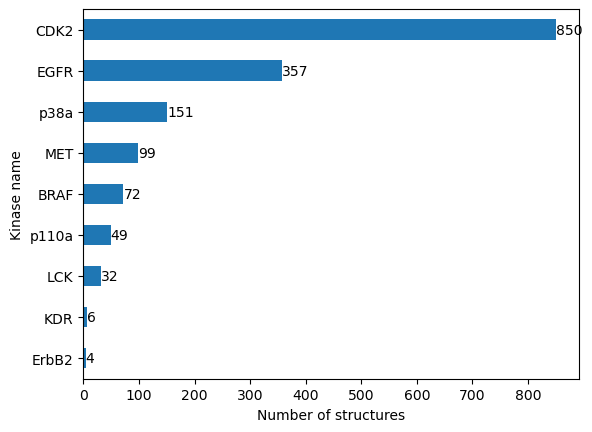

In [14]:
fig, ax = plt.subplots()
n_structures_per_kinase.plot(kind="barh", ax=ax)
ax.set_xlabel("Number of structures")
ax.set_ylabel("Kinase name")
for i, value in enumerate(n_structures_per_kinase):
    ax.text(value, i, str(value), va="center")

We see that our dataset is highly imbalanced. While some kinases are structurally resolved very often, other kinases are not. We will have to keep this in mind when interpreting our results later.

### Calculate KiSSim fingerprints

We use the `kissim` API to encode our structures as KiSSim fingerprints and save the fingerprints as CSV file.

_Note for demo mode_: We use pre-calculated KiSSim fingerprints for our kinase set (i.e. the next code cell will be skipped).

In [15]:
if DEMO:
    print("Notebook is run in demo mode - we will use pre-calculated fingerprints.")
else:
    print("Calculate and save KiSSim fingerprints...")
    # Calculate fingerprints
    from kissim.api import encode

    kissim_fingerprints = encode(structure_klifs_ids, n_cores=N_CORES)

    # Save fingerprints in csv file
    structure_klifs_ids = list(kissim_fingerprints.data.keys())
    kissim_fingerprints_array = [
        fingerprint.values_array().tolist()
        for structure_klifs_id, fingerprint in kissim_fingerprints.data.items()
    ]
    kissim_fingerprints_array = np.array(kissim_fingerprints_array)
    kissim_fingerprints_df = pd.DataFrame(kissim_fingerprints_array, index=structure_klifs_ids)
    kissim_fingerprints_df.to_csv(DATA / "kissim_fingerprints.csv")

# NBVAL_CHECK_OUTPUT

Notebook is run in demo mode - we will use pre-calculated fingerprints.


Let's load the KiSSim fingerprints from the CSV file.

In [16]:
kissim_fingerprints_df = pd.read_csv(DATA / "kissim_fingerprints.csv", index_col=0)
print(f"Matrix shape: {kissim_fingerprints_df.shape}")
print(f"Number of fingerprints: {kissim_fingerprints_df.shape[0]}")
print(f"Number of fingerprint bits: {kissim_fingerprints_df.shape[1]}")
# NBVAL_CHECK_OUTPUT

Matrix shape: (1611, 1032)
Number of fingerprints: 1611
Number of fingerprint bits: 1032


You might notice that we have slightly fewer fingerprints than structures. This can happen during the `kissim` fingerprint generation, if a structure cannot be encoded.

Let's have a look at the fingerprint DataFrame. 

- Kinase structures are stored by KLIFS ID (index)
- Each kinase is represented by $1032$ features, i.e. $85$ residues * $8$ physicochem. features + $85$ residues * $4$ distances + $12$ moments

In [17]:
kissim_fingerprints_df.head()
# NBVAL_CHECK_OUTPUT

,0,1,2,3,4,5,6,7,8,9,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
6285,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,3.0,2.0,1.0,...,13.150351,11.958837,4.717011,4.843444,4.655707,3.577213,2.771821,4.302192,3.583341,2.066700
10568,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,3.0,2.0,1.0,...,13.069152,11.883944,4.691527,5.006221,4.679352,3.531177,2.714736,4.165350,3.549843,2.138838
11187,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,3.0,2.0,1.0,...,13.297023,11.991511,4.590040,5.141397,4.699467,3.625989,2.549692,4.442117,3.699695,2.261646
4060,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,3.0,2.0,1.0,...,12.910837,11.775556,4.359330,4.844833,4.214195,3.383812,2.699580,3.860920,3.161863,2.185979
10566,2.0,0.0,2.0,-1.0,0.0,0.0,2.0,3.0,2.0,1.0,...,13.196581,12.115342,4.701176,4.690081,4.683674,3.633418,2.489983,3.972552,3.692501,0.759234


### Compare structures

Let's make a pairwise comparison of the KiSSim fingerprints. We use the `nan_euclidean_distances` method of `sklearn`, which calculates the Euclidean distance between all pairwise vectors. 

If two vectors have NaN values (which can happen if residues are not resolved in a structure), the following procedure is applied:

>  When calculating the distance between a pair of samples, this formulation ignores feature coordinates with a missing value in either sample and scales up the weight of the remaining coordinates.

Please find more information in the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.nan_euclidean_distances.html).

In [18]:
structure_distance_matrix_array = pairwise.nan_euclidean_distances(kissim_fingerprints_df.values)

In [19]:
# Create DataFrame with structure KLIFS IDs as index/columns
structure_klifs_ids = kissim_fingerprints_df.index.to_list()
structure_distance_matrix_df = pd.DataFrame(
    structure_distance_matrix_array, index=structure_klifs_ids, columns=structure_klifs_ids
)
print(f"Structure distance matrix size: {structure_distance_matrix_df.shape}")
print("Show matrix subset:")
structure_distance_matrix_df.iloc[:5, :5]
# NBVAL_CHECK_OUTPUT

Structure distance matrix size: (1611, 1611)
Show matrix subset:


,6285,10568,11187,4060,10566
6285,0.000000,13.256941,14.001474,26.391543,14.307291
10568,13.256941,0.000000,10.379779,27.882193,16.833932
11187,14.001474,10.379779,0.000000,30.962221,18.338492
4060,26.391543,27.882193,30.962221,0.000000,28.905189
10566,14.307291,16.833932,18.338492,28.905189,0.000000


### Map structure to kinase distance matrix

Note: So far we compared individual structures, but we want to compare kinases (which can be represented by several structures, as plotted above).

First, as an intermediate step, we will use the structure distance matrix but &mdash; instead of labeling the data with structure KLIFS IDs &mdash; we use the corresponding kinase name.

In [20]:
# Copy distance matrix to kinase matrix
kinase_distance_matrix_df = structure_distance_matrix_df.copy()
# Replace structure KLIFS IDs with the structures' kinase names
kinase_names = structures_df.set_index("structure.klifs_id").loc[
    structure_klifs_ids, "kinase.klifs_name"
]
kinase_distance_matrix_df.index = kinase_names
kinase_distance_matrix_df.columns = kinase_names
print("Show matrix subset:")
kinase_distance_matrix_df.iloc[:5, :5]
# NBVAL_CHECK_OUTPUT

Show matrix subset:


kinase.klifs_name,CDK2,CDK2,CDK2,CDK2,CDK2
kinase.klifs_name,,,,,
CDK2,0.000000,13.256941,14.001474,26.391543,14.307291
CDK2,13.256941,0.000000,10.379779,27.882193,16.833932
CDK2,14.001474,10.379779,0.000000,30.962221,18.338492
CDK2,26.391543,27.882193,30.962221,0.000000,28.905189
CDK2,14.307291,16.833932,18.338492,28.905189,0.000000


In this talktorial, we will consider per kinase pair the two structures that show the most similar pockets. Hence, we select the structure pair with the minimum distance as representative for a kinase pair.

In [21]:
# We unstack the matrix (each pairwise comparison in a single row)
# We group by kinase names (level=[0, 1] ensures that the order of the kinases is ignored
# We take the minimum value in each kinase pair group
# We unstack the remaining data points
kinase_distance_matrix_df = (
    kinase_distance_matrix_df.unstack().groupby(level=[0, 1]).min().unstack(level=1)
)
# Cosmetics: Remove the index and column names
kinase_distance_matrix_df.index.name = None
kinase_distance_matrix_df.columns.name = None

In [22]:
print(
    f"Structure matrix of shape {structure_distance_matrix_df.shape} "
    f"reduced to kinase matrix of shape {kinase_distance_matrix_df.shape}."
)
# NBVAL_CHECK_OUTPUT

Structure matrix of shape (1611, 1611) reduced to kinase matrix of shape (9, 9).


In [23]:
# Show matrix with background gradient
cm = sns.light_palette("green", as_cmap=True)
kinase_distance_matrix_df.style.background_gradient(cmap=cm).format("{:.3f}")

,BRAF,CDK2,EGFR,ErbB2,KDR,LCK,MET,p110a,p38a
BRAF,0.000,17.156,19.515,21.383,21.089,21.583,20.297,37.611,21.731
CDK2,17.156,0.000,18.147,21.106,19.880,17.973,18.304,36.780,19.481
EGFR,19.515,18.147,0.000,16.392,17.282,16.467,17.498,36.046,22.128
ErbB2,21.383,21.106,16.392,0.000,23.851,23.881,22.563,41.277,24.682
KDR,21.089,19.880,17.282,23.851,0.000,19.255,20.431,41.104,20.263
LCK,21.583,17.973,16.467,23.881,19.255,0.000,19.221,39.022,22.457
MET,20.297,18.304,17.498,22.563,20.431,19.221,0.000,39.414,21.983
p110a,37.611,36.780,36.046,41.277,41.104,39.022,39.414,0.000,38.530
p38a,21.731,19.481,22.128,24.682,20.263,22.457,21.983,38.530,0.000


Note: Since this is a distance matrix, lighter colors indicate similarity, darker colors dissimilarity.

### Save kinase distance matrix

In [24]:
kinase_distance_matrix_df.to_csv(DATA / "kinase_distance_matrix.csv")

## Discussion

In this talktorial, we have assessed kinase similarity using the KiSSim fingerprints, which describe physicochemical and spatial properties of pockets in kinase structures. We have reduced a _structure_ distance matrix to a _kinase_ distance matrix by selecting for each _kinase pair_ the corresponding closest _structure pair_. 

We have to keep two elements in mind:

- Pocket fingerprints like KiSSim encode the full pocket although some residues might be more important for ligand binding than others. As an alternative, one could instead use a subset of residues that have been shown to frequently interact with co-crystallized ligands.
- We only compare here the two closest structures per kinase pair, although we have &mdash; at least for kinases such as EGFR and CDK2 &mdash; much more structural data available. Aggregating multiple structures is a reasonable strategy but has two disadvantages: 
  - Some kinases have much higher coverage than others, leading to an imbalance in information content.
  - Aggregated kinase fingerprints may cause too much averaging, making pairwise kinase comparison noisier.

The kinase distance matrix above will be reloaded in __Talktorial T028__, where we compare kinase similarities from different perspectives, including the pocket structure perspective we have talked about in this talktorial.

## Quiz

1. Can you think of reasons why it is important to include physicochemical *and* spatial properties in a fingerprint?
2. Can you think of a reason why the side chain orientation and solvent exposure may be interesting features to consider in a fingerprint?
2. Can you think of research questions for which you could make use of the structure distance matrix?